In [ ]:
import cv2
import colorsys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Global variables

# Path to directories
IMGS_DIR = Path("images")
OUTPUT_DIR = Path("output")

# Grid shape for coverage calculation
GRID_SHAPE = (3, 3)

In [3]:
# Read image paths
imgs_paths: list[Path] = []
for file in Path(IMGS_DIR).iterdir():
    if file.is_file() and file.suffix.lower() in {".jpg", ".png", ".jpeg"}:
        imgs_paths.append(file)

In [ ]:
def get_distinct_colors(amount: int) -> list[tuple[int, int, int]]:
    """
    Generates a list of unique and distinct colors.
    Each color is represented as an RGB tuple.
    """
    colors = []
    for i in range(amount):
        # Evenly distribute hues in the HSV color space
        hue = i / amount
        saturation = 1.0  # Full saturation for vibrant colors
        value = 1.0  # Full brightness
        # Convert HSV to RGB and scale to 0-255
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        rgb_scaled = tuple(int(c * 255) for c in rgb)
        colors.append(rgb_scaled)

    return colors

Loaded image: images\Al_10d_0.jpg


<Figure size 640x480 with 0 Axes>

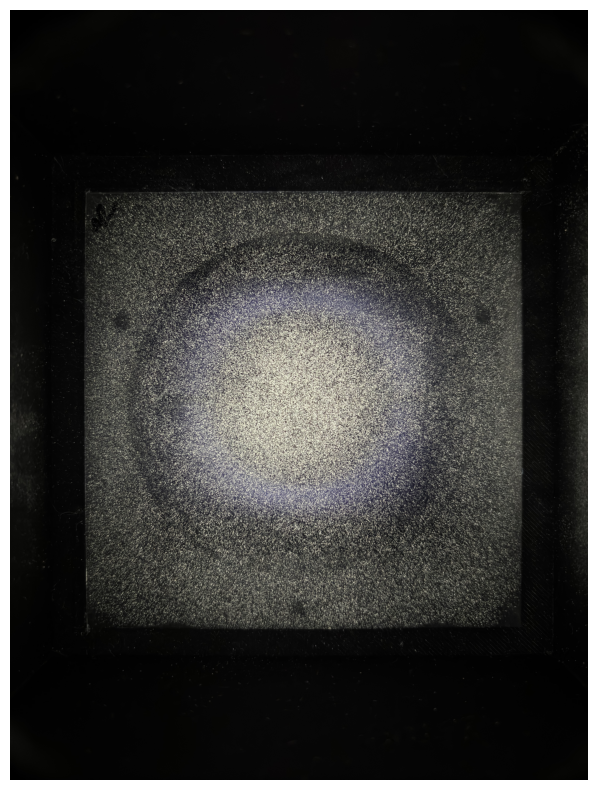

<Figure size 640x480 with 0 Axes>

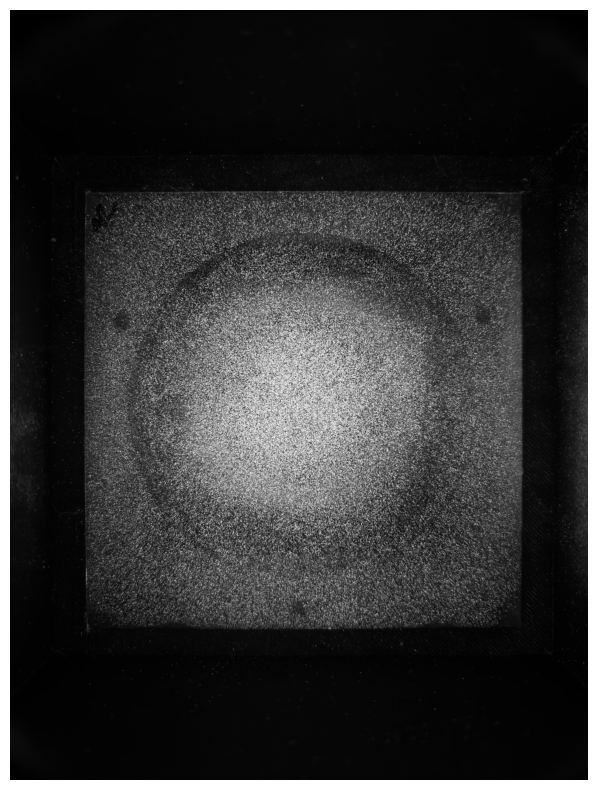

Saved image to output\Al_10d_0_gray.jpg


<Figure size 640x480 with 0 Axes>

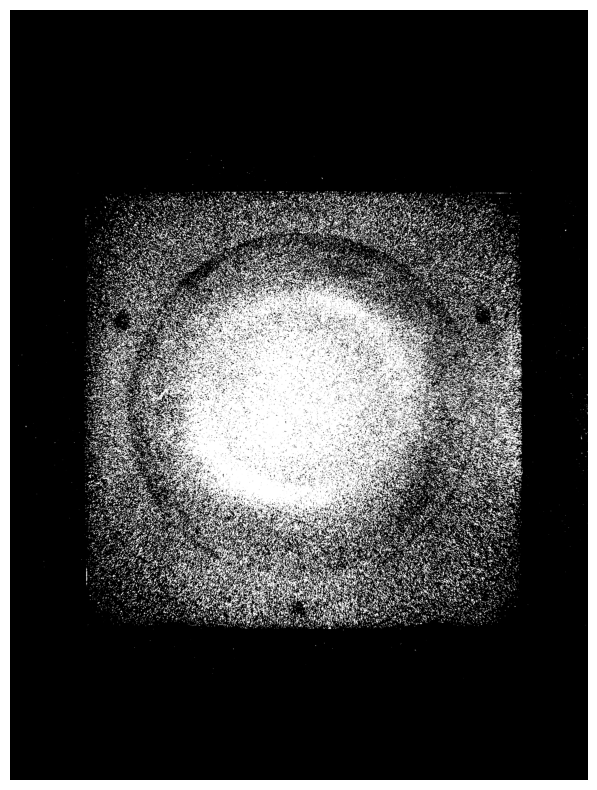

Saved image to output\Al_10d_0_thresh.jpg


<Figure size 640x480 with 0 Axes>

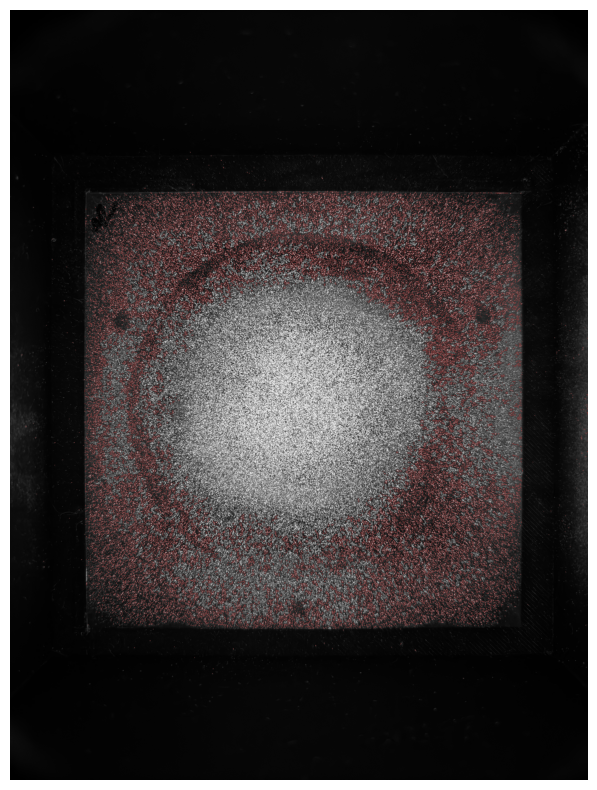

Saved image to output\Al_10d_0_contours.jpg
Detected 29560 particles.


In [26]:
def display_image(image: np.ndarray) -> None:
    # Reset the figure
    plt.clf()

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


def save_image(image: np.ndarray, path: Path) -> None:
    cv2.imwrite(str(path), image)
    print(f"Saved image to {path}")


def analyze_image(in_path: Path, out_dir: Path):
    img = cv2.imread(str(in_path), cv2.IMREAD_COLOR)
    if img is None:
        print("Failed to load image:", in_path)
        return
    print("Loaded image:", in_path)

    # # Scale down the image
    # SCALE_FACTOR = 0.5  # percent of original size
    # width = int(img.shape[1] * SCALE_FACTOR)
    # height = int(img.shape[0] * SCALE_FACTOR)
    # img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Increate sharpness by applying Gaussian blur
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    gray = cv2.addWeighted(gray, 1.5, gray, -0.5, 0)

    # Display the image
    display_image(img)
    display_image(gray)

    # Save the processed image
    output_path = out_dir / (str(in_path.stem) + "_gray" + in_path.suffix)
    save_image(gray, output_path)

    # # Create brightness histogram
    # hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    # hist = hist.flatten()

    # print("hist min", hist.min())
    # print("hist max", hist.max())
    # print("hist average", hist.mean())
    # hist[hist < 10] = 0 # Remove low values
    # # hist = hist / hist.sum()  # Normalize histogram

    # # Plot histogram
    # plt.figure(figsize=(10, 5))
    # plt.plot(hist, color='black')
    # plt.title("Brightness Histogram")

    # Apply adaptive thresholding to create a binary image
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh_overlay = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    output_path = out_dir / (str(in_path.stem) + "_thresh" + in_path.suffix)
    display_image(thresh_overlay)
    save_image(thresh_overlay, output_path)

    # Filter particles based on contour area
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    CONTOUR_AREA_MIN = 1
    CONTOUR_AREA_MAX = 500
    particles = [
        cnt
        for cnt in contours
        if CONTOUR_AREA_MIN < cv2.contourArea(cnt) < CONTOUR_AREA_MAX
    ]

    particle_overlay = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(particle_overlay, particles, -1, (0, 0, 255), 1)
    display_image(particle_overlay)
    output_path = out_dir / (str(in_path.stem) + "_contours" + in_path.suffix)
    save_image(particle_overlay, output_path)

    print(f"Detected {len(particles)} particles.")

    return None  # TODO


# Analyze single image
test_img_path = Path(IMGS_DIR, "Al_10d_0.jpg")
analyze_image(test_img_path, OUTPUT_DIR)